In [1]:
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import torch
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf
import gpzoo.pri_experiment_utilities as pexp
import scanpy as sc
from os import path
import random
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
import gpzoo.pri_experiment_utilities as putil
from torch import optim, distributions, nn

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(
/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-07-11 02:17:38.963190: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 02:17:38.976577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been regist

In [2]:
!pwd
root_path = '/engelhardt/home/pshrestha/vnngp/'
torch.manual_seed(256)

/engelhardt/home/pshrestha/vnngp/GPzoo/notebooks


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

In [5]:
dtp = "float32"
root_path = "/engelhardt/home/pshrestha/vnngp/"
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
visium_pth = path.join(rpth, "visium/")
save_pth = path.join(visium_pth, "plots/")

## Visium 

### EDA

In [22]:
ad = sq.datasets.visium_hne_adata()
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
Y_sums = np.array(np.sum(ad.raw.X > 0, axis=0))[0]
    
Y = np.array(ad.raw.X[:, Y_sums>200].todense(), dtype=int).T
X = ad.obsm['spatial']
X = X.astype('float64')
Y = Y.astype('float64')
X = rescale_spatial_coords(X)

In [23]:
Y.shape

(11925, 2688)

In [37]:
ad.uns['spatial']

{'V1_Adult_Mouse_Brain': {'images': {'hires': array([[[0.50980395, 0.52156866, 0.49411765],
           [0.50980395, 0.5176471 , 0.49411765],
           [0.50980395, 0.5176471 , 0.5019608 ],
           ...,
           [0.5019608 , 0.5137255 , 0.49019608],
           [0.5019608 , 0.5137255 , 0.49803922],
           [0.5019608 , 0.50980395, 0.49411765]],
   
          [[0.50980395, 0.5176471 , 0.49803922],
           [0.5137255 , 0.52156866, 0.49411765],
           [0.50980395, 0.5176471 , 0.49803922],
           ...,
           [0.49803922, 0.5137255 , 0.4862745 ],
           [0.49803922, 0.50980395, 0.49411765],
           [0.5019608 , 0.5137255 , 0.5019608 ]],
   
          [[0.5058824 , 0.5176471 , 0.49019608],
           [0.5137255 , 0.52156866, 0.5019608 ],
           [0.5058824 , 0.52156866, 0.5019608 ],
           ...,
           [0.5019608 , 0.5137255 , 0.49803922],
           [0.5019608 , 0.50980395, 0.49411765],
           [0.5058824 , 0.5137255 , 0.49803922]],
   
          ..

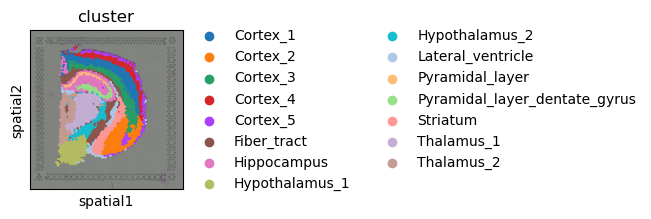

In [38]:
sq.pl.spatial_scatter(ad, color="cluster", size=2)

In [39]:
ad.layers = {"counts":ad.X.copy()} 
ad.var['deviance_poisson'] = deviancePoisson(ad.layers["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
ad.write_h5ad(path.join(root_path,"data/visium_brain_coronal.h5ad"),compression="gzip")
ad2 = ad[:,:2000]
ad2.write_h5ad(path.join(root_path,"data/visium_brain_coronal_J2000.h5ad"),compression="gzip")

Dtr_n['X'] shape: (2554, 2)
Dtr_n['Y'] shape: (2554, 18078)
Dtr['X'] shape: (2554, 2)
Dtr['Y'] shape: (2554, 18078)


2024-07-11 02:03:48.456702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17759 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-07-11 02:03:48.459187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15198 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


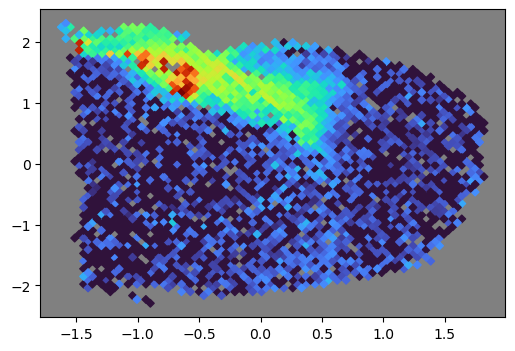

In [40]:
J = 2000
ad = read_h5ad(path.join(dpth, f"visium_brain_coronal.h5ad"))#[:,:J]
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")
print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

heatmap(Xtr,Dtr_n["Y"][:,0],marker="D",s=15)

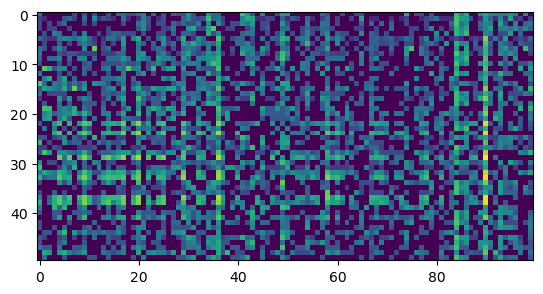

In [41]:
plt.imshow(np.log1p(Dtr["Y"])[:50,:100]) # raw data

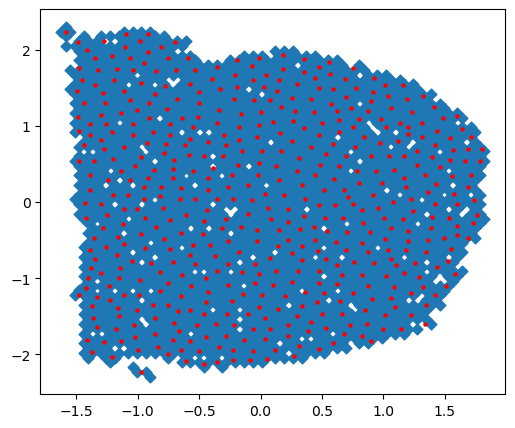

In [42]:
# Visualize Inducing Points
centers = putil.inducing_points_cluster_centers(Xtr, 500)
Z = nn.Parameter(torch.tensor(centers.cluster_centers_).type(torch.float))
Z = Z.detach().numpy()
fig,ax=plt.subplots(figsize=(6,5))
ax.scatter(Xtr[:,0],Xtr[:,1],marker="D",s=30,)
ax.scatter(Z[:,0],Z[:,1],c="red",s=5)

### Run Times

In [6]:
L = 10
M = [500, 1000, 2000]
K_small =  [2, 3, 4, 5, 6, 7, 8, 9]
K = [20, 30, 40, 50, 100, 200, 300]
lkzz_builds = [1]

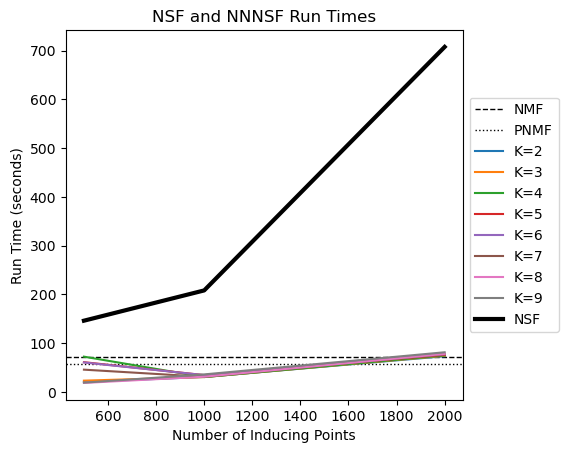

In [7]:
# compare runntime with VNNGP (different K) versus SVGP
fig, ax = plt.subplots()
times = []

# NMF
file_path = path.join(rpth, f"visium/nmf/nmf_factors_iter=1000_rs=256_L=5.pt")
results = torch.load(file_path)
plt.axhline(y=results['time'], color='black', linestyle='--', linewidth=1, label='NMF')

# PNMF
file_path = path.join(rpth, f"visium/pnmf/PNMF_L=5_lr=0.1_iter=6000_model.pt")
results = torch.load(file_path)
plt.axhline(y=results['time'], color='black', linestyle=':', linewidth=1, label='PNMF')

times = []

# VNNGP
for k in K_small:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=3000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, label=f"K={k}")

# SVGP
times = []
for m in M:
    file_path = path.join(rpth, 
                               f"visium/nsf/SVGP_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    times.append(results['time'])
sns.lineplot(x=M, y=times, color='black', label='NSF', linewidth=3)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.xticks([500, 1000, 2000])
plt.title("NSF and NNNSF Run Times")
plt.ylabel("Run Time (seconds)")
plt.xlabel("Number of Inducing Points")
fig.savefig(f'{save_pth}/visium_runntine_comparison_plot_small_k.png')

FileNotFoundError: [Errno 2] No such file or directory: '/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=20_lkzz=1_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt'

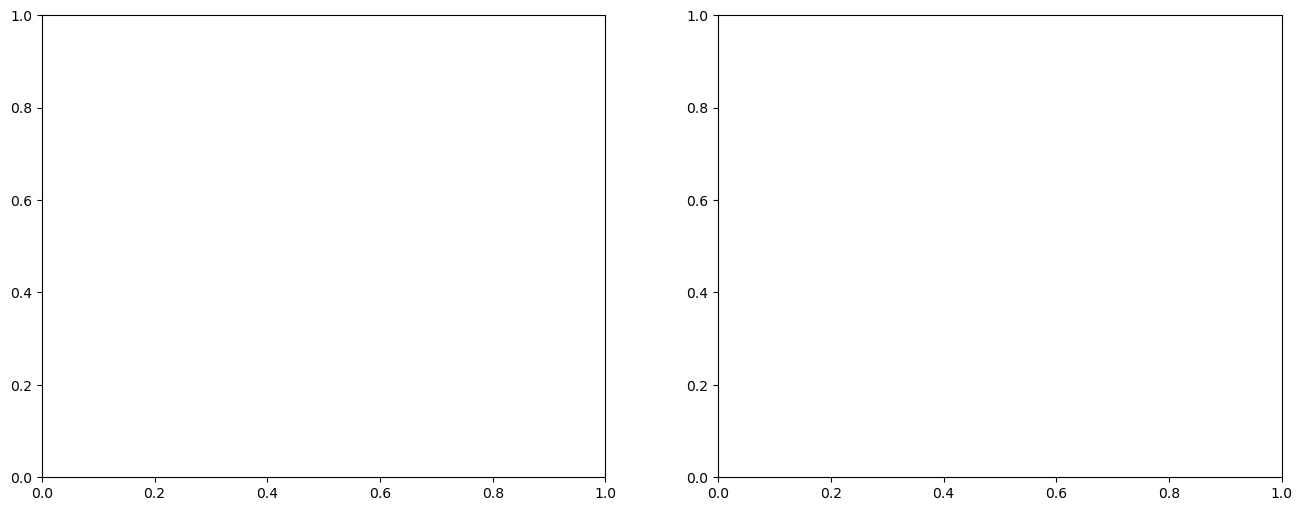

In [18]:
# compare runntime with lkzz_build=1 (left) and lkzz_build=2 (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# VNNGP
for k in K:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, ax=ax1, label=f"K={k}")
    ax1.set_title("Large Values of K")


# SVGP
times = []
for m in M:
    file_path = path.join(rpth, 
                               f"visium/nsf/SVGP_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    times.append(results['time'])
sns.lineplot(x=M, y=times, color='black', label='NSF', ax=ax2, linewidth=4)

# VNNGP
for k in K_small:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, ax=ax2, label=f"K={k}")
    ax2.set_title("Small Values of K")

times = []
# SVGP
for m in M:
    file_path = path.join(rpth, 
                               f"visium/nsf/SVGP_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    times.append(results['time'])
sns.lineplot(x=M, y=times, color='black', label='NSF', ax=ax1, linewidth=4)

ax1.set_xticks([500, 1000, 2000])
ax2.set_xticks([500, 1000, 2000])
plt.legend()
plt.suptitle("NSF and NNNSF Runntimes")

Text(0.5, 0.98, 'NSF and NNNSF Runntimes')

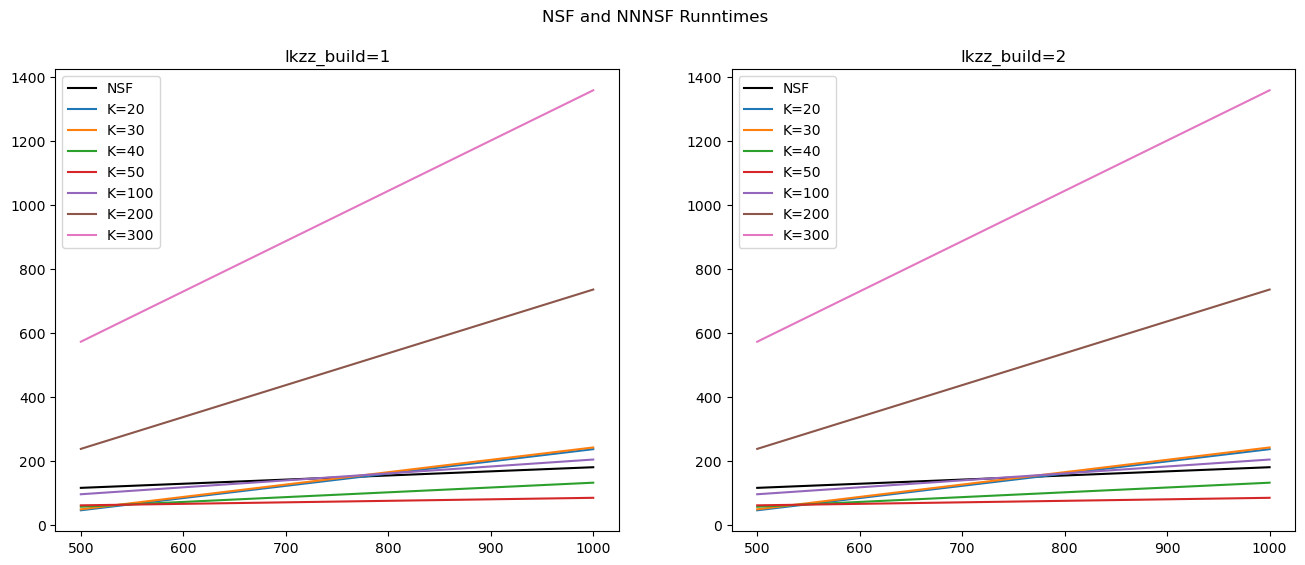

In [22]:
# compare runntime with lkzz_build=1 (left) and lkzz_build=2 (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
times = []

# SVGP
for m in M:
    file_path = path.join(rpth, 
                               f"visium/nsf/SVGP_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    times.append(results['time'])
sns.lineplot(x=M, y=times, color='black', label='NSF', ax=ax1)

# VNNGP
for k in K:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, ax=ax1, label=f"K={k}")
    ax1.set_title("lkzz_build=1")


# SVGP
times = []
for m in M:
    file_path = path.join(rpth, 
                               f"visium/nsf/SVGP_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    times.append(results['time'])
sns.lineplot(x=M, y=times, color='black', label='NSF', ax=ax2)

# VNNGP
for k in K:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, ax=ax2, label=f"K={k}")
    ax2.set_title("lkzz_build=2")

plt.legend()
plt.suptitle("NSF and NNNSF Runntimes")

Text(0.5, 1.0, 'NNNSF Run Times')

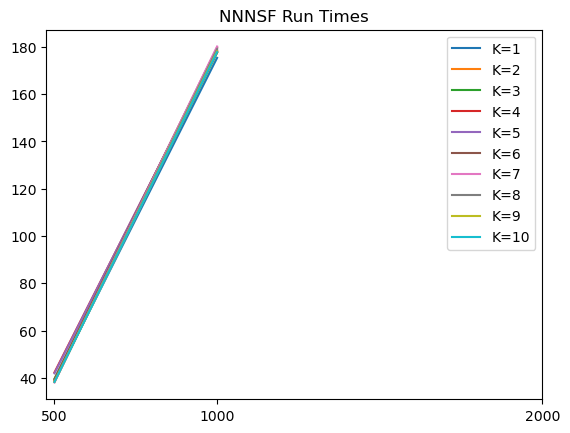

In [25]:
# compare runntime with VNNGP (different K) versus SVGP
fig, ax = plt.subplots()
times = []

# VNNGP
for k in K_small:
    times = []
    for m in M:
        file_path = path.join(rpth, 
                           f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M={m}_L={L}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
        results = torch.load(file_path)
        times.append(results['time'])
    sns.lineplot(x=M, y=times, label=f"K={k}")

plt.legend()
plt.xticks([500, 1000, 2000])
plt.title("NNNSF Run Times")

### Losses

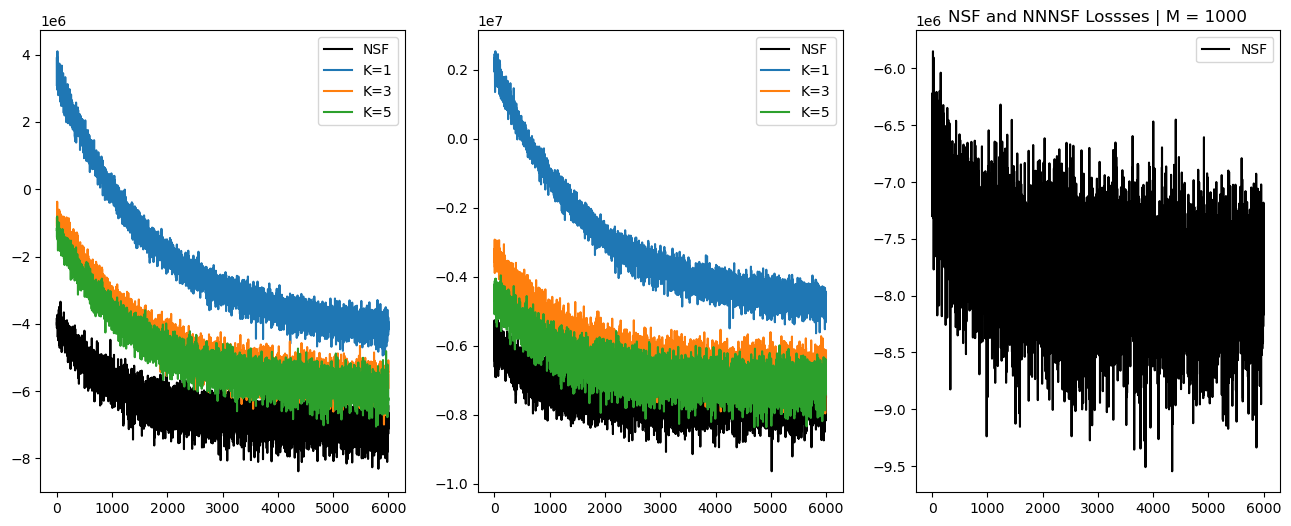

In [14]:
# compare losses with VNNGP (different K) versus SVGP
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# SVGP
file_path = path.join(rpth, f"visium/nsf/SVGP_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
results = torch.load(file_path)
sns.lineplot(results['losses'], color='black', label='NSF', ax=ax1)


file_path = path.join(rpth, f"visium/nsf/SVGP_M=1000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
results = torch.load(file_path)
sns.lineplot(results['losses'], color='black', label='NSF', ax=ax2)


file_path = path.join(rpth, f"visium/nsf/SVGP_M=2000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
results = torch.load(file_path)
sns.lineplot(results['losses'], color='black', label='NSF', ax=ax3)

# VNNGP

K = [1, 3, 5]

for k in K:
    times = []
    file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    sns.lineplot(results['losses'], label=f"K={k}", ax=ax1)

    file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    sns.lineplot(results['losses'], label=f"K={k}", ax=ax2)

    #file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=2000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    #results = torch.load(file_path)
    #sns.lineplot(results['losses'], label=f"K={k}", ax=ax3)

plt.title("NSF and NNNSF Lossses | M = 1000")
plt.legend()

#plt.legend()
#plt.title("NSF and NNNSF Runntimes")

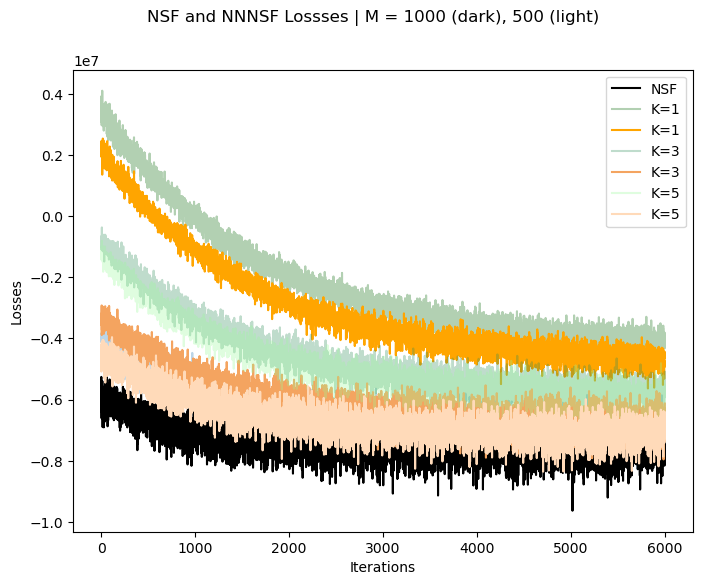

In [22]:
# compare runntime with VNNGP (different K) versus SVGP
fig, ax = plt.subplots(figsize=(8, 6))

# SVGP
file_path = path.join(rpth, f"visium/nsf/SVGP_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
results = torch.load(file_path)
sns.lineplot(results['losses'], alpha=0.3)


file_path = path.join(rpth, f"visium/nsf/SVGP_M=1000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
results = torch.load(file_path)
sns.lineplot(results['losses'], color='black', label='NSF')


#file_path = path.join(rpth, f"visium/nsf/SVGP_M=2000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
#results = torch.load(file_path)
#sns.lineplot(results['losses'], color='black', label='NSF')

# VNNGP

K = [1, 3, 5]
colors_500 = ['darkgreen', 'seagreen', 'palegreen']
colors_1000 = ['orange', 'sandybrown', 'peachpuff']
for i, k in enumerate(K):
    times = []
    file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    sns.lineplot(results['losses'], alpha=0.3, label=f"K={k}", color=colors_500[i])

    file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=1000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    results = torch.load(file_path)
    sns.lineplot(results['losses'], label=f"K={k}", color=colors_1000[i])

    #file_path = path.join(rpth, f"visium/nnnsf/VNNGP_K={k}_lkzz=1_M=2000_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_model.pt")
    #results = torch.load(file_path)
    #sns.lineplot(results['losses'], label=f"K={k}", ax=ax3)

plt.suptitle("NSF and NNNSF Lossses | M = 1000 (dark), 500 (light)")
plt.legend()
plt.ylabel("Losses")
plt.xlabel("Iterations")

ppath = path.join(save_pth, 'plots')
fig.savefig(f"{file_path}_loss_pots.png")

### Visualize Factors

In [33]:
L = 15
N = [3000]
M = [500, 1000, 2000]
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#K = [1]
lkzz_builds = [1, 2]

In [29]:
dicts = {
        'L': 10, 
        'M': 2000, 
        'K': 4,
        'sigma': 0.1, 
        'lengthscale': 0.07, 
        'jtr': 1e-2,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1}

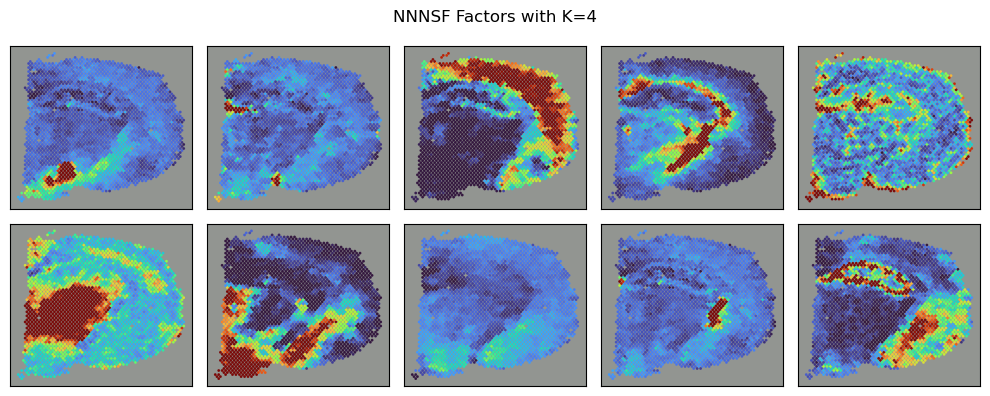

In [30]:
# Visualize Factors

import warnings
warnings.filterwarnings("ignore") 

save_path = path.join(root_path, "results/visium/nnnsf/")
factors, loadings = pexp.preloaded_nmf_factors(f"/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L={dicts['L']}.pt")
NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
pexp.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']


#print(loadings)
file_path = f"VNNGP_K={dicts['K']}_lkzz={dicts['lkzz_build']}_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=3000_bs=128_NMFinit_state_dict.pth"
dict_path = path.join(save_path, file_path)
NNNSF.load_state_dict(torch.load(dict_path))
X = torch.tensor(X).type(torch.float)
X = X.clone().detach().type(torch.float)
NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors

size=2
fig1, axes1 = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
    
moran_idx, moranI = putil.dims_autocorr(factors, X)
#X_test = torch.tensor(putil.rescale_spatial_coords(adata.obsm['spatial'])).type(torch.float)*50
#putil.plot_factors(means, X, moran_idx=moran_idx, size=7, s=1.0, alpha=0.8, ax=axes)

#axes = big_axes[start_row:end_row].reshape(2, 5)  # Reshape to 2D (2 rows, 5 cols)
putil.plot_factors(means, X, moran_idx=moran_idx, size=2, s=1.0, alpha=0.9, ax=axes1)
#axes[0,2].set_title(f'NNNSF Factors with K={k}')  # Set title on the first subplot of each K
    
plt.suptitle(f"NNNSF Factors with K={dicts['K']}")
fig.show()
ppath = path.join(save_path, 'plots')
#fig.savefig(f'{ppath}/{file_path}_combined_k_plot.png')


In [ ]:
print(factors.shape)
print(factors[:1].shape)

In [ ]:
means.shape

### Evaluating Variance per Factor

In [7]:
def calculate_variance_explained(W, X, Y, factor_num=None):
    """
    Calculate the amount of variance captured by each factor.

    Parameters:
    model : nn.Module
        Trained VNNGP model.
    X : torch.Tensor
        Original data matrix of size [N, D].
    Y : torch.Tensor
        Response matrix of size [L, N].

    Returns:
    explained_variance_ratios : np.ndarray
        Proportion of variance explained by each factor.
    """
    #X = torch.tensor(X).type(torch.float)
    #X = X.clone().detach().type(torch.float)
    #model.cpu()
    #qF, _, _ = model.prior(X)
    
    #means = torch.exp(qF.mean).detach().numpy() # means = factors
    #W = (model.W).cpu()
    W_transformed = nn.functional.softplus(W.T)

    #W_transformd = W_transformed.detach().numpy()
    y_nnnsf = (np.exp(means.T)).dot(W_transformed.detach().numpy())

    # Calculate the variance captured by each factor
    fvariances = np.var(np.exp(means), axis=1)

    # Calculate ratio of actual/output variance explaine
    total_model_var = np.var(y_nnnsf, axis=0)
    #print(total_model_var)
    Y = np.array(Y)
    total_actual_var = np.var(Y, axis=1)
    #print(Y.shape[0])
    #print(y_nnnsf.shape[1])
    var_ratios =  (total_model_var.sum() / y_nnnsf.shape[0]) / (total_actual_var.sum() / Y.shape[1])
    #print(total_model_var)
    #print(total_actual_var)
    #print(var_ratio)
    if factor_num != None:
        return fvariances[factor_num], var_ratios
    
    return fvariances, var_ratios


In [25]:
import warnings
warnings.filterwarnings("ignore") 

K = [1, 2, 3, 5, 6, 8, 9]
M = [500, 1000, 2000]
X, Y = pexp.load_visium()
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt")
moran_idx, moranI = putil.dims_autocorr(factors, X)
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

inducing_point_variances = []
nsf_variances = []

#NSF
for m in M:
    dicts = {
            'L': 10, 
            'M': m, 
            'K': 1,
            'sigma': 0.1, 
            'lengthscale': 0.07, 
            'jtr': 1e-2,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1}
    file_path = f"nsf/SVGP_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_state_dict.pth"
    dict_path = path.join(visium_pth, file_path)
    X_array = np.array(X.cpu())
    Y_array = np.array(Y.cpu())
    NSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='SVGP', kwargs=dicts)
    pexp.model_grads(NSF)
    NSF.prior.jitter = dicts['jtr']
    NSF.load_state_dict(torch.load(dict_path))
                
    X = torch.tensor(X).type(torch.float)
    Y = torch.tensor(Y).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NSF.cpu()
    qF, _, _ = NSF.prior(X)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    W = (NSF.W).cpu()
                
    explained_variance, total_variance = calculate_variance_explained(W, X, Y)  
    nsf_variances.append(total_variance)

for m in M:
    variances = []
    for k in K:
        dicts = {
            'L': 10, 
            'M': m, 
            'K': k,
            'sigma': 0.1, 
            'lengthscale': 0.07, 
            'jtr': 1e-2,
            'batch_size': 128,
            'lr': 1e-3,
            'rs': 256,
            'lkzz_build': 1}
        file_path = f"nnnsf/VNNGP_K={k}_lkzz={dicts['lkzz_build']}_M={m}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=3000_bs=128_NMFinit_state_dict.pth"
        dict_path = path.join(visium_pth, file_path)
        NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
        pexp.model_grads(NNNSF)
        NNNSF.prior.jitter = dicts['jtr']
        NNNSF.load_state_dict(torch.load(dict_path))
            
        X = torch.tensor(X).type(torch.float)
        X = X.clone().detach().type(torch.float)
        Y = torch.tensor(Y).type(torch.float)
        NNNSF.cpu()
        qF, _, _ = NNNSF.prior(X, kwargs=dicts)
        means = torch.exp(qF.mean).detach().numpy() # means = factors
        W = (NNNSF.W).cpu()
            
        explained_variance, total_variance = calculate_variance_explained(W, X, Y)
        variances.append(total_variance)   
    inducing_point_variances.append(variances)

In [26]:
print(nsf_variances)

[1.3968574296001797, 1.1627237292917507, 2.0538562259823605]


In [27]:
inducing_point_variances[2].insert(0, nsf_variances[2])
inducing_point_variances[1].insert(0, nsf_variances[1])
inducing_point_variances[0].insert(0, nsf_variances[0])

8


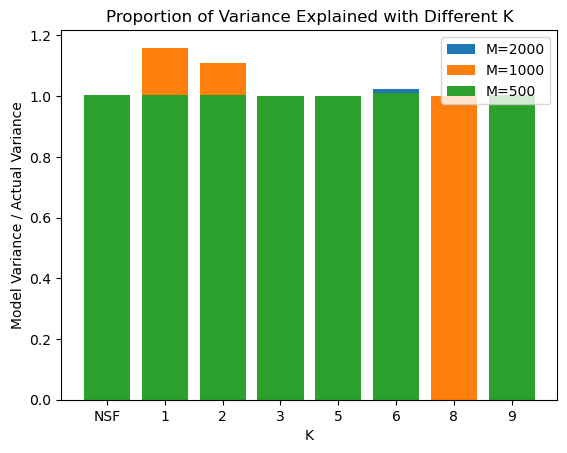

In [32]:
#m2000 = inducing_point_variances[2].insert(0, nsf_variances[2])
#m1000 = inducing_point_variances[1].insert(0, nsf_variances[1])
#m500 = inducing_point_variances[0].insert(0, nsf_variances[0])
print(len(inducing_point_variances[0]))
plt.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[2])/2000), label="M=2000")
plt.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[1])/1000), label="M=1000")
plt.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[0])/500), label="M=500")
plt.xlabel('K')
plt.ylabel('Model Variance / Actual Variance')
plt.title('Proportion of Variance Explained with Different K')
xticks = ['NSF', 1, 2, 3, 5, 6, 8, 9]
plt.xticks(ticks=[i for i in range(1,9)],labels=xticks)
plt.legend()
plt.show() 
#print(save_pth)
#print(visium_pth)
#fig.savefig(f"{visium_pth}/{file_path}_variance.png")

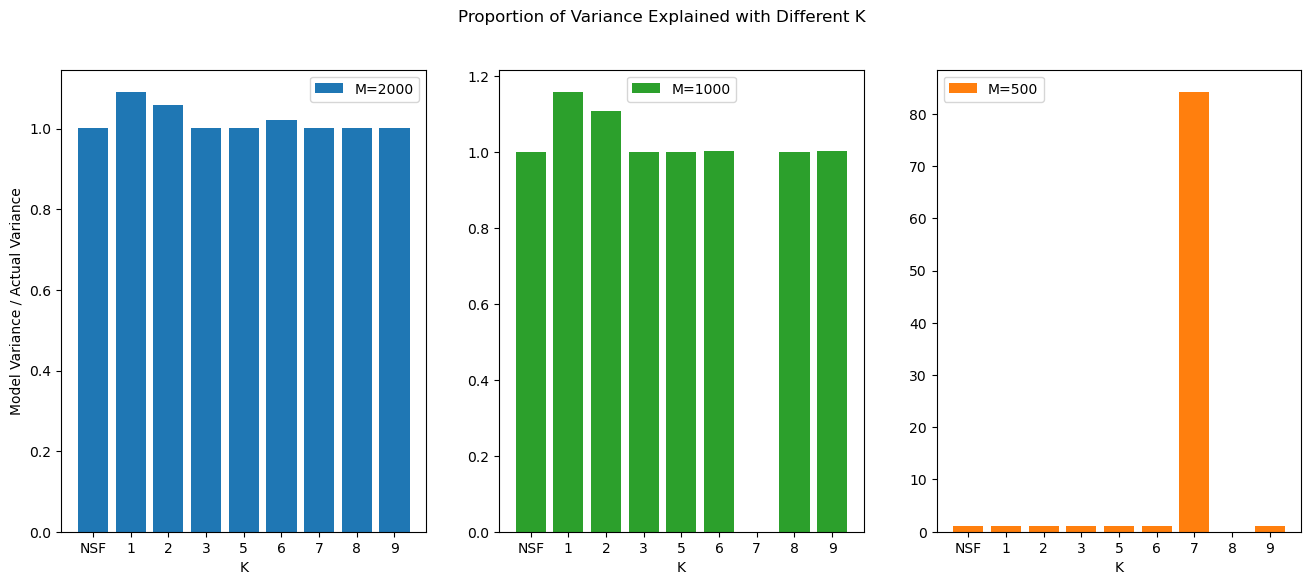

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(16, 6))
ax1.set_ylabel('Model Variance / Actual Variance')
ax1.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[2])/2000), label="M=2000", color='tab:blue')
ax2.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[1])/1000), label="M=1000", color='tab:green')
ax3.bar(range(1, len(variances) + 1), np.exp(np.array(inducing_point_variances[0])/500), label="M=500", color='tab:orange')
plt.suptitle('Proportion of Variance Explained with Different K')
xticks = ['NSF', 1, 2, 3, 5, 6, 7, 8, 9]
plt.xticks(ticks=[i for i in range(1,10)],labels=xticks)
#ax2.set_xticks(ticks=[i for i in range(1,11)],labels=xticks)
#ax3.set_xticks(ticks=[i for i in range(1,11)],labels=xticks)
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_xlabel('K')
ax2.set_xlabel('K')
ax3.set_xlabel('K')
plt.show() 
#print(save_pth)
#print(visium_pth)
#fig.savefig(f"{visium_pth}/{file_path}_variance.png")

### Factorization Progression as Neighbors Increased

In [11]:
def plot_one_factor(factors, X, factor_num, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)
    factors = factors[moran_idx]
    ax.scatter(X[:, 0], X[:,1], c=factors[factor_num], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('xkcd:gray')

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()
/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/pri_experiment_utilities.py:192: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/tmp/ipykernel_1207785/3516885406.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).type(torch.float)
/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:93: UserWarning: To copy construct from 

Text(0.5, 0.98, 'Cortex Region Representation with Varying Number of Neighbors')

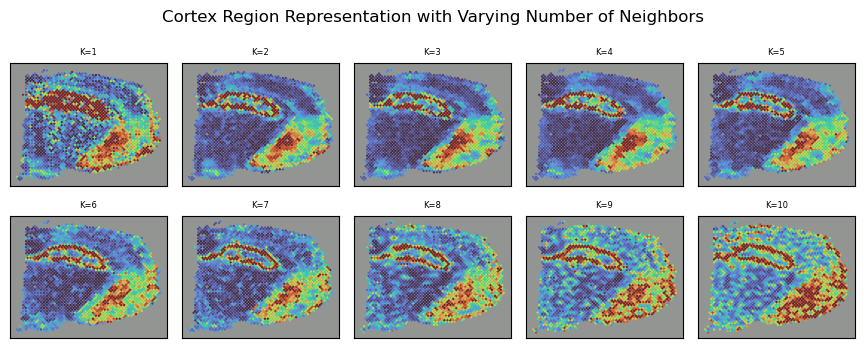

In [28]:
save_path = path.join(root_path, "results/visium/nnnsf/")
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X, Y = pexp.load_visium()
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt")
moran_idx, moranI = putil.dims_autocorr(factors, X)
#print(loadings)

size=1.75
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
axes = axes.flatten()
L = len(factors)

for i,k in enumerate(K):
    dicts = {
        'L': 10, 
        'M': 2000, 
        'K': k,
        'sigma': 0.1, 
        'lengthscale': 0.07, 
        'jtr': 1e-2,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1}
    file_path = f"VNNGP_K={k}_lkzz={dicts['lkzz_build']}_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=3000_bs=128_NMFinit_state_dict.pth"
    dict_path = path.join(save_path, file_path)
    NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
    pexp.model_grads(NNNSF)
    NNNSF.prior.jitter = dicts['jtr']
    NNNSF.load_state_dict(torch.load(dict_path))
    
    X = torch.tensor(X).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NNNSF.cpu()
    qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    
    curr_ax = axes[i]
    plot_one_factor(means, X, 9, moran_idx=moran_idx, ax=curr_ax, size=0.5, s=0.3, alpha=0.9)
    #fvariance, ratio = calculate_variance_explained(NNNSF, X, 2)
    curr_ax.set_title(f"K={k}", size=6)

fig.suptitle("Cortex Region Representation with Varying Number of Neighbors")
#ppath = path.join(save_path, 'plots'
#fig.savefig(f'{ppath}/{file_path}_k_plot_cortex.png')

FileNotFoundError: [Errno 2] No such file or directory: '/engelhardt/home/pshrestha/vnngp/results/visium/nnnsf/VNNGP_K=1_lkzz=2_M=500_L=10_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_state_dict.pth'

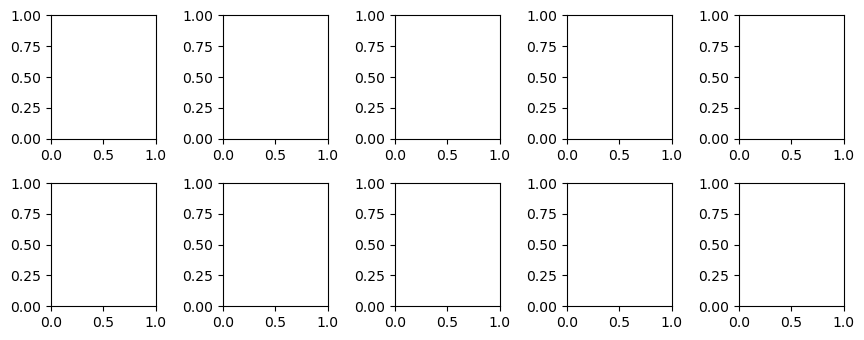

In [25]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X, Y = pexp.load_visium()
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt")
moran_idx, moranI = putil.dims_autocorr(factors, X)
#print(loadings)

size=1.75
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
axes = axes.flatten()
L = len(factors)

for i,k in enumerate(K):
    dicts = {
        'L': 10, 
        'M': 500, 
        'K': k,
        'sigma': 0.1, 
        'lengthscale': 0.07, 
        'jtr': 1e-2,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1}
    file_path = f"VNNGP_K={k}_lkzz={dicts['lkzz_build']}_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_state_dict.pth"
    dict_path = path.join(save_path, file_path)
    NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
    pexp.model_grads(NNNSF)
    NNNSF.prior.jitter = dicts['jtr']
    NNNSF.load_state_dict(torch.load(dict_path))
    
    X = torch.tensor(X).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NNNSF.cpu()
    qF, _, _ = NNNSF.prior(X)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    
    curr_ax = axes[i]
    plot_one_factor(means, X, moran_idx[2], moran_idx=moran_idx, ax=curr_ax, size=2, s=1.0, alpha=0.9)
    fvariance, ratio = calculate_variance_explained(NNNSF, X, 2)
    curr_ax.set_title(f"K={k} | fVar = {fvariance:.3f} | tVar ={ratio:.3f} ", size=6)

fig.suptitle("Cortex Region Representation with Varying Number of Neighbors")
ppath = path.join(save_path, 'plots')
#fig.savefig(f'{ppath}/{file_path}_k_plot_cortex.png')

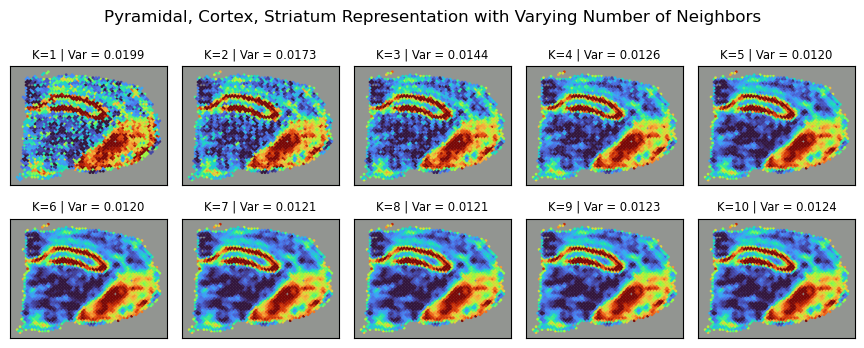

In [187]:
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X, Y = pexp.load_visium()
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt")
moran_idx, moranI = putil.dims_autocorr(factors, X)
#print(loadings)

size=1.75
fig, axes = plt.subplots(2, 5, figsize=(size*5, size*2), tight_layout=True)
axes = axes.flatten()
L = len(factors)

for i,k in enumerate(K):
    dicts = {
        'L': 10, 
        'M': 1000, 
        'K': k,
        'sigma': 0.1, 
        'lengthscale': 0.07, 
        'jtr': 1e-2,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 2}
    #plt.subplot(L//5, 5, k+1)
    curr_ax = axes[i]
    file_path = f"VNNGP_K={k}_lkzz={dicts['lkzz_build']}_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=6000_bs=128_NMFinit_state_dict.pth"
    dict_path = path.join(save_path, file_path)
    NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
    pexp.model_grads(NNNSF)
    NNNSF.prior.jitter = dicts['jtr']
    NNNSF.load_state_dict(torch.load(dict_path))
    X = torch.tensor(X).type(torch.float)
    X = X.clone().detach().type(torch.float)
    NNNSF.cpu()
    qF, _, _ = NNNSF.prior(X)
    means = torch.exp(qF.mean).detach().numpy() # means = factors
    plot_one_factor(means, X, moran_idx[9], moran_idx=moran_idx, ax=curr_ax, size=2, s=1.0, alpha=0.9)
    explained_variance = calculate_variance_explained(NNNSF, X, 9)
    curr_ax.set_title(f"K={k} | Var = {explained_variance:.4f}", size='small')
fig.suptitle("Pyramidal, Cortex, Striatum Representation with Varying Number of Neighbors")
ppath = path.join(save_path, 'plots')
#fig.savefig(f'{ppath}/{file_path}_k_plot_mix.png')

### Plot Top Genes

In [17]:
def plot_top_genes(factors, loadings, X, y, num_genes= 5, size=2, alpha=0.8, s=0.1, names=None):

    max_val_factors = np.percentile(factors, 99)
    min_val_factors = np.percentile(factors, 1)

    L = len(factors)//2


    loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)

    order = torch.argsort(loadings_softmax,dim=0, descending=True)

    y_top = y[order[:num_genes]]
    fig, ax = plt.subplots(L, num_genes+1, figsize=(size*(num_genes+1), size*L), tight_layout=True)

    for i in range(L):
        

        curr_ax = ax[i, 0]
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val_factors, vmax=max_val_factors, alpha=alpha, cmap='turbo', s=s)
        curr_ax.invert_yaxis()
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

        names = ad.var.index[order[:num_genes, i]]


        for j in range(num_genes):
            
            curr_ax = ax[i, j+1]
            curr_ax.scatter(X[:, 0], X[:,1], c=y_top[j, i], alpha=alpha, cmap='turbo', s=s)
            curr_ax.invert_yaxis()
            curr_ax.set_xticks([])
            curr_ax.set_yticks([])
            curr_ax.set_facecolor('xkcd:gray')

            curr_ax.set_title(names[j], x=0.03, y=.88, fontsize="small", c="white",
                         ha="left", va="top", fontweight="bold")
    return fig

In [34]:
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/visium/nmf/nmf_factors_iter=1000_rs=256_L=10.pt")
#print(loadings)
NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
pexp.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']
file_path = f"VNNGP_K={5}_lkzz={dicts['lkzz_build']}_M={dicts['M']}_L={dicts['L']}_lr=0.001_jtr=0.01_iter=3000_bs=128_NMFinit_state_dict.pth"
dict_path = path.join(save_path, file_path)
NNNSF.load_state_dict(torch.load(dict_path))
X = torch.tensor(X).type(torch.float)
X = X.clone().detach().type(torch.float)
NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
    
means = torch.exp(qF.mean).detach().numpy() # means = factors

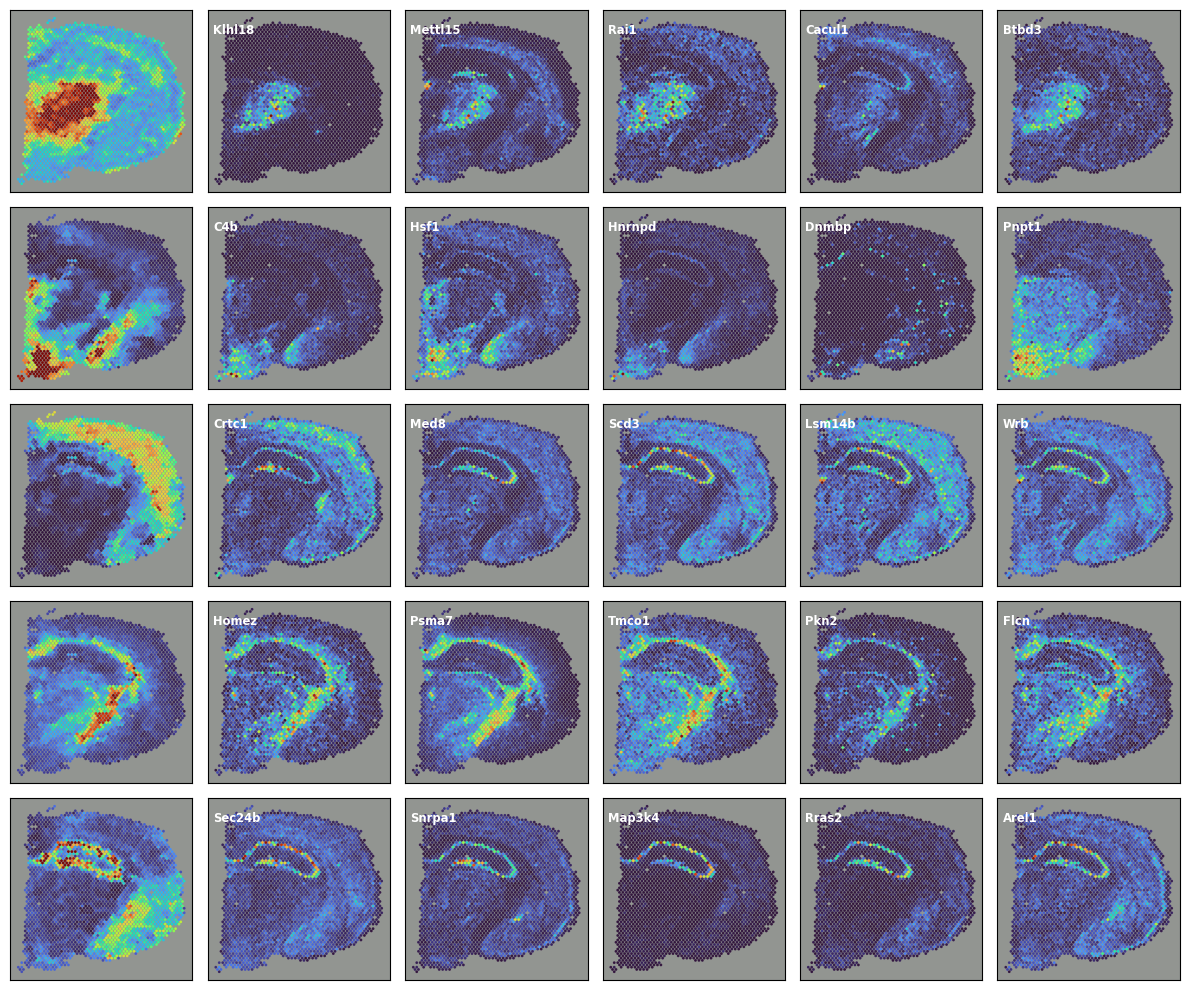

In [43]:
W = torch.nn.functional.softplus(NNNSF.W)
fig = plot_top_genes(means, W, X, Y, num_genes=5, size=2, alpha=0.9, s=1.0)
fig.show()
fig.savefig(f'{save_pth}/visium_gene_validation_k=8.png')

## Slideseq

In [11]:
ad = sq.datasets.slideseqv2()
ad = ad.raw.to_adata()
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(ad, min_counts=100)
sc.pp.filter_genes(ad, min_cells=10)
    #idx = list(range(adata.shape[0]))
    #random.shuffle(idx)
    #adata = adata[idx]
    
Dtr, Dval = anndata_to_train_val(ad, sz="scanpy")
Y = Dtr['Y'].T
Y = Y[~ad.var.MT]
X = Dtr['X']*50.0

/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:164: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


/engelhardt/home/pshrestha/anaconda3/envs/vnngp2/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


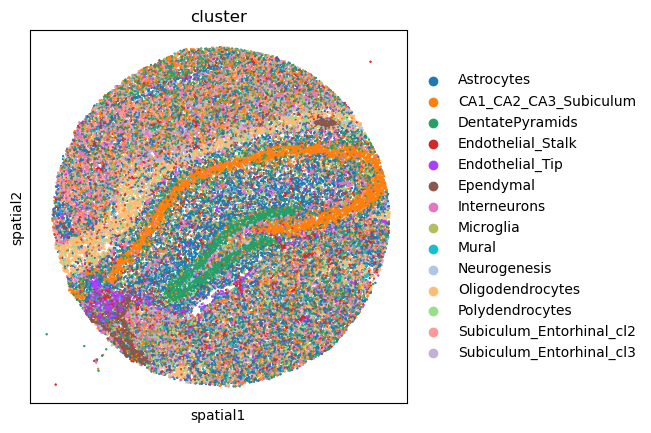

In [14]:
sq.pl.spatial_scatter(ad, color="cluster", size=1, shape=None);

In [51]:
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

#print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
#print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")
print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
#Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
#Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

#heatmap(X.T,Y[:,0],marker="D",s=15)

KeyError: 'counts'

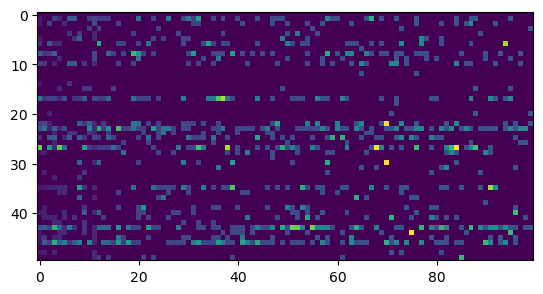

In [52]:
plt.imshow(np.log1p(Y)[:50,:100]) # raw data

In [8]:
spth = path.join(rpth, "slideseq/")

In [9]:
dicts = {
        'L': 15, 
        'M': 3000, 
        'K': 8,
        'sigma': 0.1, 
        'lengthscale': 0.07, 
        'jtr': 1e-2,
        'batch_size': 128,
        'lr': 1e-3,
        'rs': 256,
        'lkzz_build': 1}

In [ ]:
results/slideseq/nnnsf/VNNGP_K=8_lkzz=1_M=3000_L=15_lr=0.001_jtr=0.01_iter=20000_bs=128_NMFinit_plot.png

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/gp.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  little_Kzz = torch.tensor(little_Kzz, device=Kzz.device).float()


Text(0.5, 0.98, 'Slideseq NNNSF Factors with K=8')

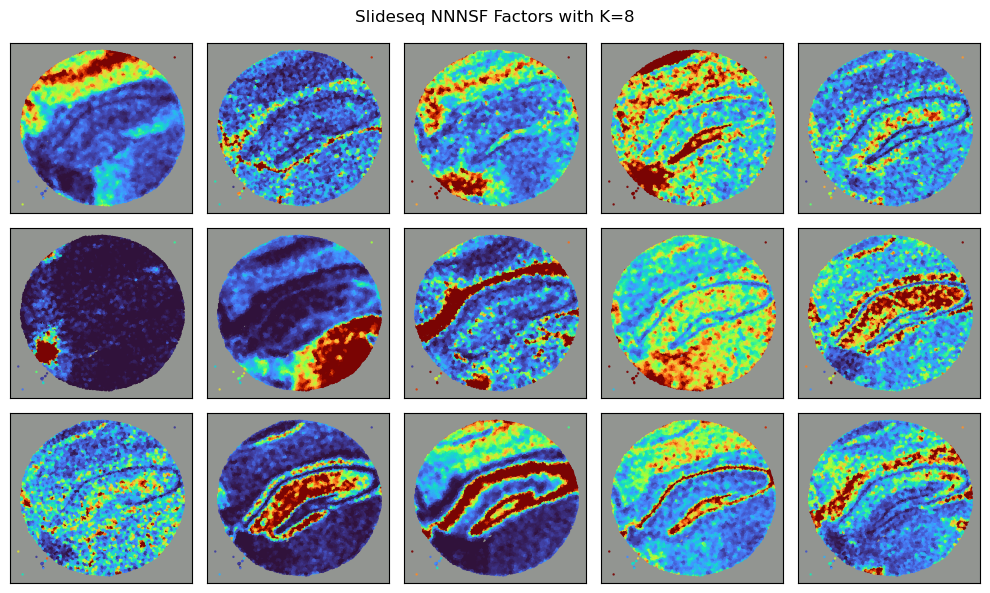

In [15]:
factors, loadings = pexp.preloaded_nmf_factors("/engelhardt/home/pshrestha/vnngp/results/slideseq/nmf/nmf_factors_iter=1000_rs=256_L=15.pt")
#print(loadings)
NNNSF = pexp.build_model(X, Y, loadings=loadings, factors=factors, model_type='VNNGP', kwargs=dicts)
pexp.model_grads(NNNSF)
NNNSF.prior.jitter = dicts['jtr']
file_path = f"nnnsf/VNNGP_K=8_lkzz=1_M=3000_L=15_lr=0.001_jtr=0.01_iter=20000_bs=128_NMFinit_state_dict.pth"
dict_path = path.join(spth, file_path)
NNNSF.load_state_dict(torch.load(dict_path))
X = torch.tensor(X).type(torch.float)
X = X.clone().detach().type(torch.float)
NNNSF.cpu()
qF, _, _ = NNNSF.prior(X, kwargs=dicts)
means = torch.exp(qF.mean).detach().numpy() # means = factors

size=2
fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
    
moran_idx, moranI = putil.dims_autocorr(factors, X)
#X_test = torch.tensor(putil.rescale_spatial_coords(adata.obsm['spatial'])).type(torch.float)*50
#putil.plot_factors(means, X, moran_idx=moran_idx, size=7, s=1.0, alpha=0.8, ax=axes)
putil.plot_factors(np.exp(means), X, moran_idx=moran_idx, size=2, s=0.5, alpha=0.9, ax=axes)
plt.suptitle(f"Slideseq NNNSF Factors with K={8}")
#axes[0,2].set_title(f'NNNSF Factors with K={k}')  # Set title on the first subplot of each K

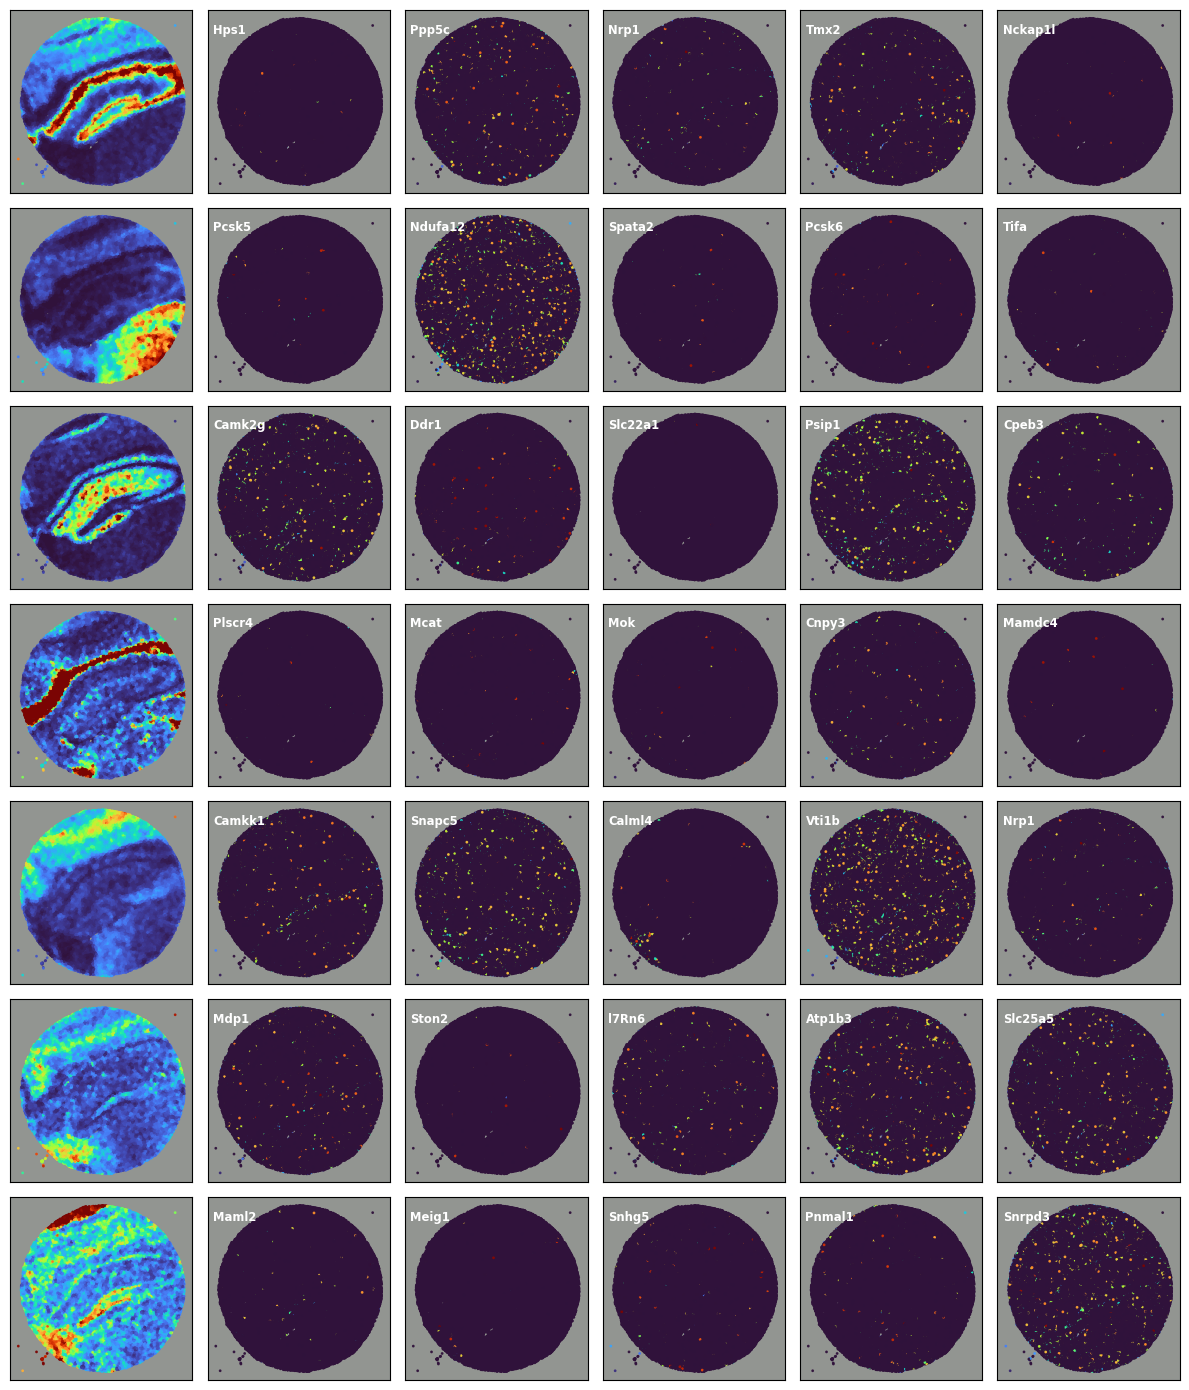

In [19]:
W = torch.nn.functional.softplus(NNNSF.W)
fig = plot_top_genes(np.exp(means), W, X, Y, num_genes=5, size=2, alpha=0.9, s=1.0)
fig.show()
#fig.savefig(f'{save_pth}/visium_gene_validation_k=8.png')

In [21]:
print(Y.shape)

(17702, 39694)
